<h1>Evaluations of NNet_Agent</h1> 

In [3]:
import os
import sys
import numpy as np
import glob
import csv

import sys

sys.path.append('..')

from matplotlib.colors import ListedColormap
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent, NN_Agent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility
from pommerman import my_utility
from pommerman import constants
from pommerman.NN.pommerman_neural_net import PommermanNNet

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from io import BytesIO

from skimage.transform import rescale

nn_args = {
    'input_channels': 8,
    'board_x': constants.BOARD_SIZE_ONE_VS_ONE,
    'board_y': constants.BOARD_SIZE_ONE_VS_ONE,
}

def visual_matrix(mat, ax, image=None, alpha=0.3):
    x_step = 1
    y_step = 1
    x_offset = 0
    y_offset = 0
    if image is None:
        ax.matshow(mat, cmap=ListedColormap(['w']))
    else:
        ax.imshow(image, alpha=alpha)
        x_step = len(image)/mat.shape[1]
        y_step = len(image)/mat.shape[0]
        x_offset = x_step/2
        y_offset = y_step/2
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            y = x_offset + i * y_step
            x = y_offset + j * x_step
            c = mat[j, i]
            ax.text(y, x, str(c), va='center', ha='center', fontsize=12)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

In [4]:
agent_colors = {'Tie': '#FFBB5B',
                'SimpleAgent': '#FF5656', ##'#FF3262', 
                'SimpleCarefulAgent': '#960000', #'#FF5E9B',
                'UCT-Agent': '#00FF00',
                'UCT-ActionPruning-Agent': '#009E1C',
                'MiniMax-UCT-Agent': '#058B8C',
                'AlphaZeroAgent': '#02A7FF',
                'AlphaZero-RewardShaping-Agent': '#014694'
               }

<h2>NNet_Agent</h2>

<h3>Overview:</h3>

<h4>NNet_Agent</h4>

* performs a MCTS at each action.
* selection (if all children available): using ucb $Qsa[(s, a)] + C * Ps[s][a] * math.sqrt(Ns[s]) / (1 + Nsa[(s, a)])$
* expansion (if not all children available): expand random unseen child. One expansion step expands 'my' and 'opponent' action.
* rollout: - <b>IF</b> node is terminal: get reward and backprobagate. <b>ELSE</b>: evaluate expanded node by nnet. Backprobagate Value from NNet.
* backprobagation: backprobagate rewards for 'me' and 'opponent' not the same. 'my' rewards update only 'my' Qsa, 'opponent' rewards update only 'opponent' Qsa.
* get action probability: return normalized distribution over $Nsa[(s, a)]$ (greedy: return maximum of $Nsa[(s, a)]$)

<h4>Learning process</h4>

* Self play
* Collect for each agent and each action: action-probs, canonical board state, reward (+rotated and mirrored)
* add to train examples
* start training the network
* evaluate network by playing old vs new network
* update if new nnet is better

<h4>Canonical board presentation:</h4>

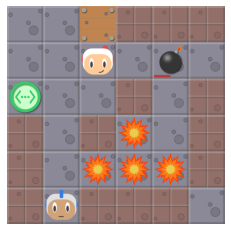

In [5]:
# Passage = 0, Rigid = 1, Wood = 2, Bomb = 3, Flames = 4
# ExtraBomb = 6, IncrRange = 7, Kick = 8, Agent0 = 10, Agent1 = 11
game_type = constants.GameType(4)

board = [[ 0,  0,  2,  1,  1,  1],
         [ 0,  0, 10,  0,  3,  0],
         [ 7,  0,  0,  1,  0,  1],
         [ 1,  0,  1,  4,  0,  1],
         [ 1,  0,  4,  4,  4,  1],
         [ 1, 11,  1,  1,  1,  0]]
bomb_info = [(0, 5, 2, None)]

game_state = my_utility.get_gamestate(board, bomb_info)
game_data = my_utility.get_gamedata(game_state, game_type)

data = BytesIO()
my_utility.get_texture(data, game_data, None)
image = mpimg.imread(data)

#downscale
image = rescale(image, 0.25, anti_aliasing=False, multichannel=True)

plt.axis('off')
imgplot = plt.imshow(image)

Numpy-Array bit coded:
* Bit 1: Rigid
* Bit 2: Wood
* Bit 3: Item
* Bit 4: Me
* Bit 5: Opponent
* Bit 6-9: Bomb life
* Bit 10-12: Bomb strength
* Bit 13-14: Flame life

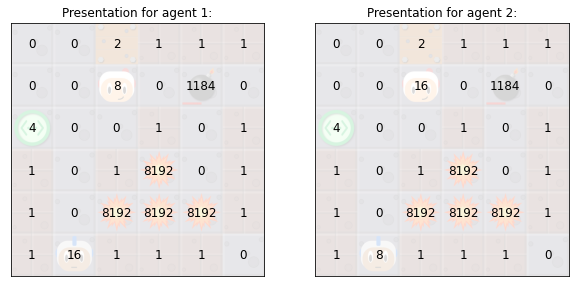

In [6]:
c_board_str_1, c_board_1 = NN_Agent.get_canonical_board_str_from_data(game_data, 0)
c_board_str_2, c_board_2 = NN_Agent.get_canonical_board_str_from_data(game_data, 1)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
titles = ['Presentation for agent 1:', 'Presentation for agent 2:']
axes = [axs[0], axs[1]]
mat = [c_board_1, c_board_2]
for i in range(len(mat)):
    axes[i].set_title(titles[i])
    visual_matrix(mat[i], axes[i], image, alpha=0.2)

<h4>NNet-Input</h4>

Split canonical board into 8 channels:
* Rigid - layer
* Wood - layer
* Item - layer
* Me - layer
* Opponent - layer
* Bomb life - layer
* Bomb strength - layer
* Flame life - layer

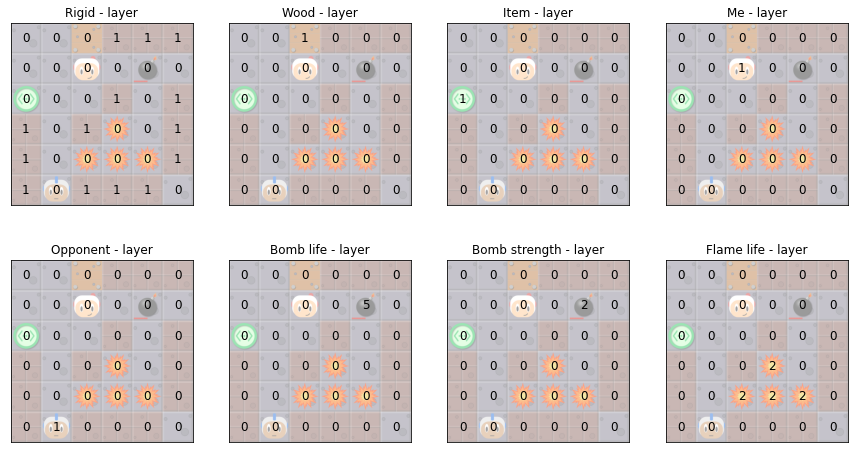

In [7]:
_, c_board = NN_Agent.get_canonical_board_str_from_data(game_data, 0)

nnet = PommermanNNet(**nn_args)
nn_input = nnet.get_nn_input(c_board)

fig, axs = plt.subplots(2, 4, figsize=(15,8))
titles = ['Rigid - layer', 'Wood - layer', 'Item - layer', 'Me - layer', 'Opponent - layer', 'Bomb life - layer', 'Bomb strength - layer', 'Flame life - layer']
axes = [axs[0,0], axs[0,1], axs[0,2], axs[0,3], axs[1,0], axs[1,1], axs[1,2], axs[1,3]]
for i in range(nn_input.shape[0]):
    axes[i].set_title(titles[i])
    visual_matrix(nn_input[i], axes[i], image, 0.5)

<h4>NNet-Architecture</h4>

* Conv2d (channels=512, kernel=3, stride=1, padding=1)
* BatchNorm2d (channels=512)
* Relu
* Conv2d (channels=512, kernel=3, stride=1, padding=1)
* BatchNorm2d (channels=512)
* Relu
* Conv2d (channels=512, kernel=3, stride=1)
* BatchNorm2d (channels=512)
* Relu
* Conv2d (channels=512, kernel=3, stride=1)
* BatchNorm2d (channels=512)
* Relu


* View to 1d


* Linear (size=1024)
* BatchNorm1d
* Relu
* Dropout (p=0.3)
* Linear (size=512)
* BatchNorm1d
* Relu
* Dropout (p=0.3)


* Conv2d (channels=512, kernel=3, stride=1, padding=1)
* BatchNorm2d (channels=512)


* pi: Linear(size=action_size)
* v: Linear(size=1)

<h4>Training</h4>

Loss function:

$L = \sum_t (v_{\theta}(s_t) - z_t)^2 - \pi_t log(p_{\theta}(s_t))$

<h4>Results</h4>

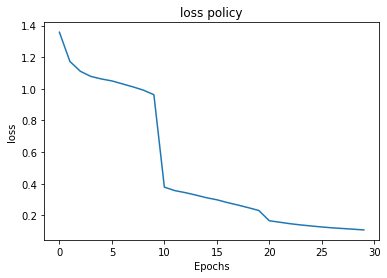

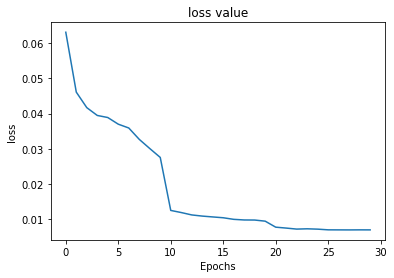

In [9]:
model_path = 'C:\\tmp\\Model\\analyse_2'

def read_loss_file(path):
    loss_pi = []
    loss_vi = []
    
    nnet_id = 1
    loss_file = os.path.join(path, f'nnet_{nnet_id}_loss.csv')
    while (os.path.exists(loss_file)):
        with open(loss_file, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=';', quotechar='|')
            for row in spamreader:
                if len(row) == 3:
                    loss_pi.append(float(row[1]))
                    loss_vi.append(float(row[2]))
        nnet_id += 1
        loss_file = os.path.join(path, f'nnet_{nnet_id}_loss.csv')
    return np.array(loss_pi), np.array(loss_vi)

loss_pi, loss_vi = read_loss_file(model_path)

plt.plot(loss_pi)
plt.title('loss policy')
plt.xlabel('Epochs')
plt.ylabel('loss') 
plt.show()

plt.plot(loss_vi)
plt.title('loss value')
plt.xlabel('Epochs')
plt.ylabel('loss') 
plt.show()

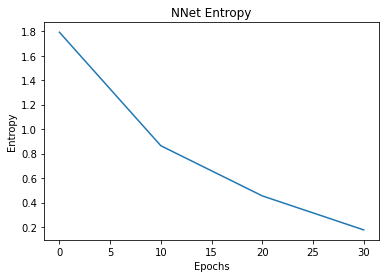

In [10]:
def get_nnet_checkpoints(path):
    nnets = []
    nnet_id = 1
    nnet_path = os.path.join(path, f'nnet_{nnet_id}.pth.tar')
    while (os.path.exists(nnet_path)):
        nnets.append(nnet_path)
        nnet_id += 1
        nnet_path = os.path.join(path, f'nnet_{nnet_id}.pth.tar')
    return nnets

def get_board_predictions(game_data, nnet, agent_id):
    _, c_board = NN_Agent.get_canonical_board_str_from_data(game_data, agent_id)
    a_pos = game_data.agents[agent_id].position
    
    pos = []
    ps = []
    vs = []
    c_board[a_pos] = 0
    
    for row in range(c_board.shape[0]):
        for col in range(c_board.shape[1]):
            if c_board[row, col] == 0:
                c_board[row, col] = 8 * (1 + agent_id)
                nn_input = nnet.get_nn_input(c_board)
                #print('input:', c_board)
                p, v = nnet.predict(nn_input)
                #print('result:', v)
                pos.append((row, col))
                ps.append(p)
                vs.append(v)
                c_board[row, col] = 0

    return pos, np.vstack(ps), np.vstack(vs)

def calc_mean_entropy(_probs):
    if len(_probs.shape) == 1:
        return - np.sum(_probs * np.log(_probs))
    else:
        return - np.sum(_probs * np.log(_probs)) / len(_probs)
    
def get_epoch_predictions(game, nnet_cps, es):
    _board_values = []
    _board_probs = []
    _eval_pos = None
    for _nnet_cp in nnet_cps:
        _nnet = PommermanNNet(**nn_args)

        if _nnet_cp:
            _head, _tail = os.path.split(_nnet_cp)
            _nnet.load_checkpoint(_head, _tail)

        _pos, _ps, _vs = get_board_predictions(game, _nnet, 0)
        _board_values.append(_vs)
        _board_probs.append(_ps)
        _eval_pos = _pos
    return _eval_pos, _board_values, _board_probs

epoch_step = 10
nnet_checkpoints = [None]
nnet_checkpoints.extend(get_nnet_checkpoints(model_path))

eval_pos, board_values, board_probs = get_epoch_predictions(game_data, nnet_checkpoints, epoch_step)
                          
mean_entropy = []
for mp in board_probs:
    mean_entropy.append(calc_mean_entropy(mp))

x_axis = np.array(list(range(len(mean_entropy)))) * epoch_step
plt.title('NNet Entropy')
plt.xlabel('Epochs')
plt.ylabel('Entropy') 
plt.plot(x_axis, mean_entropy)
plt.show()

<h5>Board values</h5>

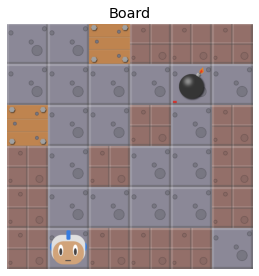

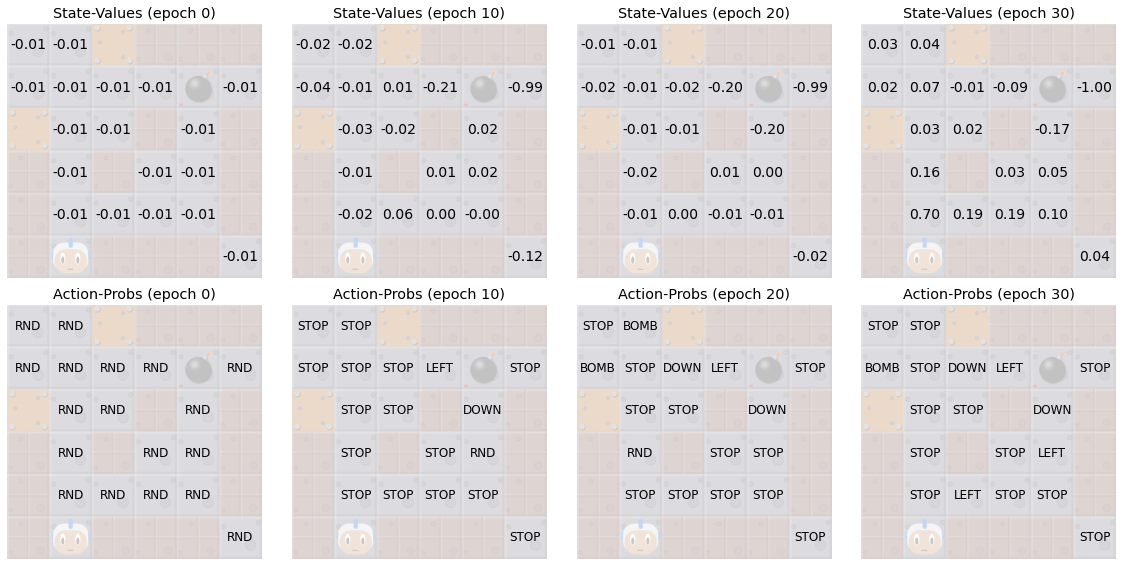

In [31]:
def plot_nnet_pred_values(game_data, agent_id, nnet_cps, epoch_step=10, filename=None):
    _png = BytesIO()
    
    a_pos = game_data.agents[agent_id].position
    game_data.board[a_pos] = 0
    my_utility.get_texture(_png, game_data, None)
    game_data.board[a_pos] = 10 + agent_id
    _img = mpimg.imread(_png)

    #downscale
    _board_img = rescale(_img, 0.25, anti_aliasing=False, multichannel=True)
    

    plt.axis('off')
    imgplot = plt.imshow(_board_img)
    plt.title('Board')
    
    if filename:
        plt.tight_layout()
        plt.savefig(filename + '.png')
    
    plt.show()
    
    # print value predictions
    _e = 0
    _pic_len = len(_board_img) / game_data.board.shape[0]
    
    _eval_pos, _values, _probs = get_epoch_predictions(game_data, nnet_cps, epoch_step)
    
    if len(_values) < 4:
        fontsize1 = '14'
        fontsize2 = '12'
        matplotlib.rcParams.update({'font.size': 12})
    else:
        fontsize1 = '14'
        fontsize2 = '12'
        matplotlib.rcParams.update({'font.size': 12})
        

    plt.figure(figsize=(4*len(_values), 8))
    grid = int(f'2{len(_values)}0')
    plot_num = 1
    for i, b_v in enumerate(_values):
        plt.subplot(grid + plot_num)
        plot_num += 1
        plt.axis('off')
        imgplot = plt.imshow(_board_img, alpha=0.3)

        plt.title(f'State-Values (epoch {_e})')
        for j, pos in enumerate(_eval_pos):
            plt.text(pos[1] * _pic_len + _pic_len/2, pos[0] * _pic_len + _pic_len/2,
                     "{:.2f}".format(b_v[j][0]), va='center', ha='center', fontsize=fontsize1)
        _e += epoch_step
       
    # print probs predictions
    _e = 0
    for i, b_p in enumerate(_probs):
        plt.subplot(grid + plot_num)
        plot_num += 1
        plt.axis('off')
        imgplot = plt.imshow(_board_img, alpha=0.3)

        actions = ['STOP', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'BOMB']
        plt.title(f'Action-Probs (epoch {_e})')
        for j, pos in enumerate(_eval_pos):
            #print(f'{pos}: {[((x / np.sum(b_p[j]))*100) for x in b_p[j]]}')
            text = 'RND' if np.max(b_p[j]) < 0.5 else actions[(np.argmax(b_p[j]))]
            #text = b_p[j][5]
            #text = '{:.2f}'.format(text)
            plt.text(pos[1] * _pic_len + _pic_len/2, pos[0] * _pic_len + _pic_len/2,
                     text, va='center', ha='center', fontsize=fontsize2)
        _e += epoch_step
        
    plt.axis('off')
    if filename:
        plt.tight_layout()
        plt.savefig(filename + '_Results.png')
        
    plt.show()
    
filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\AlphaZero_ExampleBoard'
    
board = [[ 0,  0,  2,  1,  1,  1],
         [ 0,  0, 10,  0,  3,  0],
         [ 2,  0,  0,  1,  0,  1],
         [ 1,  0,  1,  0,  0,  1],
         [ 1,  0,  0,  0,  0,  1],
         [ 1, 11,  1,  1,  1,  0]]
bomb_info = [(0, 1, 2, None)]

game_state = my_utility.get_gamestate(board, bomb_info)
game_data = my_utility.get_gamedata(game_state, game_type)

epoch_step = 10
nnet_checkpoints = [None]
nnet_checkpoints.extend(get_nnet_checkpoints(model_path))

plot_nnet_pred_values(game_data, 0, nnet_checkpoints, epoch_step, filename)

<h1>Own reward function</h1>

In [13]:
model_rew_path = 'C:\\tmp\\Model\\analyse_Reward'

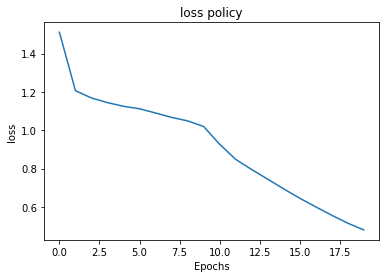

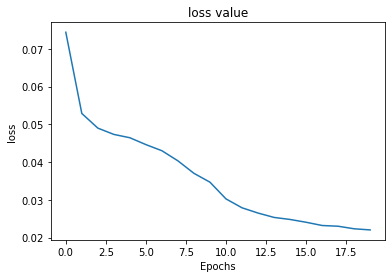

In [14]:
loss_pi, loss_vi = read_loss_file(model_rew_path)

plt.plot(loss_pi)
plt.title('loss policy')
plt.xlabel('Epochs')
plt.ylabel('loss') 
plt.show()

plt.plot(loss_vi)
plt.title('loss value')
plt.xlabel('Epochs')
plt.ylabel('loss') 
plt.show()

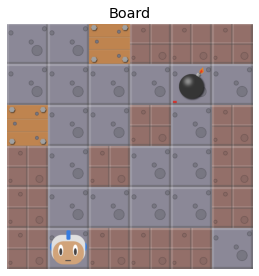

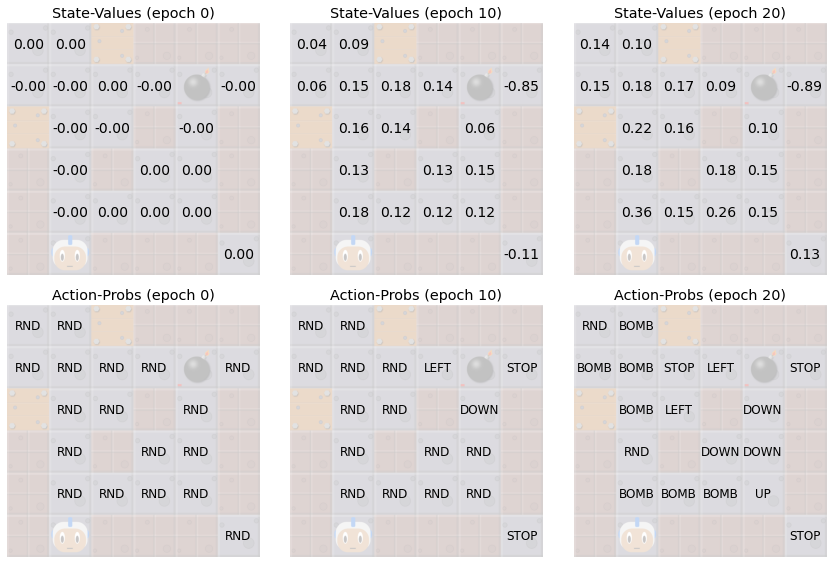

In [32]:
board = [[ 0,  0,  2,  1,  1,  1],
         [ 0,  0, 10,  0,  3,  0],
         [ 2,  0,  0,  1,  0,  1],
         [ 1,  0,  1,  0,  0,  1],
         [ 1,  0,  0,  0,  0,  1],
         [ 1, 11,  1,  1,  1,  0]]
bomb_info = [(0, 1, 2, None)]

game_state = my_utility.get_gamestate(board, bomb_info)
game_data = my_utility.get_gamedata(game_state, game_type)

epoch_step = 10
nnet_checkpoints = [None]
nnet_checkpoints.extend(get_nnet_checkpoints(model_rew_path))

filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\AlphaZeroReward_ExampleBoard'

plot_nnet_pred_values(game_data, 0, nnet_checkpoints, epoch_step, filename)

<h1>Evaluation</h1>

In [9]:
import pandas as pd 
import math
import matplotlib.pyplot as plt
import numpy as np
import json 

In [12]:
#load file
csv_azr_care = pd.read_csv("C:\\tmp\\Results\\CSV\\AlphaZeroAgentvarIter_SimpleCarefulAgent_03-09-2021_14-20-56.csv", sep=';')
csv_azr_simple = pd.read_csv("C:\\tmp\\Results\\CSV\\AlphaZeroAgentvarIter_SimpleAgent_03-10-2021_18-27-51.csv", sep=';')

csv_az_care = pd.read_csv("C:\\tmp\\Results\\CSV\\AlphaZeroAgentvarIter_SimpleCarefulAgent_03-08-2021_22-35-28.csv", sep=';')
csv_az_simple = pd.read_csv("C:\\tmp\\Results\\CSV\\AlphaZeroAgentNORewvarIter_SimpleAgent_03-11-2021_07-22-32.csv", sep=';')

# filter
csv_azr_care

,p1,p2,result,winner,time,steps,add_info_p1,add_info_p2
0,SimpleCarefulAgent,AlphaZeroAgent_noDL_iter1,Result.Win,0,0.458561,44,{},"{'avgTime': 0.00893190909090909, 'avgRolloutDe..."
1,SimpleCarefulAgent,AlphaZeroAgent_noDL_iter1,Result.Win,1,0.979503,104,{},"{'avgTime': 0.007809663461538463, 'avgRolloutD..."
2,SimpleCarefulAgent,AlphaZeroAgent_noDL_iter1,Result.Tie,-1,0.650484,68,{},"{'avgTime': 0.007905352941176471, 'avgRolloutD..."
3,SimpleCarefulAgent,AlphaZeroAgent_noDL_iter1,Result.Win,0,1.023376,108,{},"{'avgTime': 0.007855018518518518, 'avgRolloutD..."
4,SimpleCarefulAgent,AlphaZeroAgent_noDL_iter1,Result.Win,0,0.123848,15,{},"{'avgTime': 0.006798599999999999, 'avgRolloutD..."
...,...,...,...,...,...,...,...,...
995,AlphaZeroAgent_noDL_iter140,SimpleCarefulAgent,Result.Win,0,38.242197,67,"{'avgTime': 0.5680532686567166, 'avgRolloutDep...",{}
996,AlphaZeroAgent_noDL_iter140,SimpleCarefulAgent,Result.Win,0,63.432337,112,"{'avgTime': 0.5640678571428569, 'avgRolloutDep...",{}
997,AlphaZeroAgent_noDL_iter140,SimpleCarefulAgent,Result.Win,1,43.494877,69,"{'avgTime': 0.6276684492753623, 'avgRolloutDep...",{}
998,AlphaZeroAgent_noDL_iter140,SimpleCarefulAgent,Result.Win,0,52.635972,87,"{'avgTime': 0.602341206896552, 'avgRolloutDept...",{}


In [13]:
def getResultDataFrame(df, p, agent_name):
    columns = ['iterations', 'win', 'tie', 'loss']
    data = {'iterations': [], 'win': [], 'tie': [], 'loss': [], 'avgtime': []}
    iter = 0
    for index, row in df.iterrows():
        side = 1
        AgentName = row['p1']
        if row['p2'].startswith(agent_name):
            AgentName = row['p2']
            side = 2
            
        if p > 0 and p != side:
            continue
            
        AgentName = AgentName + '_'
            
        i = float(AgentName[AgentName.index('iter')+4:AgentName.index('_', AgentName.index('iter'))])
        if iter != i:
            data['iterations'].append(i)
            data['win'].append(0)
            data['tie'].append(0)
            data['loss'].append(0)
            data['avgtime'].append(np.array([]))
        iter = i
        
        if row['result'] == 'Result.Win':
            winner = row[int(row['winner'])]
            if winner.startswith(agent_name):
                data['win'][-1] += 1
            else:
                data['loss'][-1] += 1
        elif row['result'] == 'Result.Tie':
            data['tie'][-1] += 1
        else:
            raise ValueError('ERROR')
          
        info = row[f'add_info_p{side}'].replace("'", "\"").replace('True', 'true').replace('False', 'false')
        info = json.loads(info)
        data['avgtime'][-1] = np.append(data['avgtime'][-1], info['avgTime'])
        
    df = pd.DataFrame(data)
    
    return df

def getFeatureResultDataFrame(df, p, feature):
    columns = [feature]
    data = {'iterations': [], feature: []}
    iter = 0
    n = 0
    for index, row in df.iterrows():
        side = 1
        AgentName = row['p1']
        if AgentName == 'SimpleAgent':
            AgentName = row['p2']
            side = 2
            
        if p > 0 and p != side:
            continue
            
        AgentName = AgentName + '_'
            
        i = int(AgentName[AgentName.index('iter')+4:AgentName.index('_', AgentName.index('iter'))])
        if iter != i:
            n = 0
            data['iterations'].append(i)
            data[feature].append(0)
        iter = i
        n += 1
        
        data[feature][-1] += (row[feature] - data[feature][-1]) / n
        
    df = pd.DataFrame(data)
    return df

In [14]:
# WIN-LOSS graph
from matplotlib import rc

def showResultPlt(df, title, barWidth, a1, a2, colors, symmetric_x=False, lines=False, filename=None, over_time=False):
    iters = list(df['iterations'])
    r = iters
    
    if symmetric_x:
        r = list(range(len(r)))
        
    if over_time:
        r = list(df['avgtime'])
        for i, t in enumerate(r):
            r[i] = t.mean()
        

    # From raw value to percentage
    totals = [i+j+k for i,j,k in zip(df['win'], df['tie'], df['loss'])]
    winBars = [i / j * 100 for i,j in zip(df['win'], totals)]
    tieBars = [i / j * 100 for i,j in zip(df['tie'], totals)]
    lossBars = [i / j * 100 for i,j in zip(df['loss'], totals)]

    # plot
    plt.figure(figsize=(8,8))
    plt.rcParams['font.size'] = '14'
    
    if not lines:
        names = [str(i) for i in iters]
        
        # Create green Bars
        plt.bar(r, winBars, color=colors[a1], edgecolor='white', width=barWidth, label=f'{a1} won')
        # Create orange Bars
        plt.bar(r, tieBars, bottom=winBars, color=colors['Tie'], edgecolor='white', width=barWidth, label=f'tie')
        # Create blue Bars
        plt.bar(r, lossBars, bottom=[i+j for i,j in zip(winBars, tieBars)], color=colors[a2], edgecolor='white', width=barWidth, label=f'{a2} won')
        plt.xticks(r, names)
    else:
        plt.plot(r, winBars, color=colors[a1], linewidth=barWidth, label=f'{a1} won')
        plt.plot(r, tieBars, color=colors['Tie'], linewidth=barWidth, label=f'tie')
        plt.plot(r, lossBars, color=colors[a2], linewidth=barWidth, label=f'{a2} won')
        
        
    # Custom x axis
    plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    if over_time:
        plt.xlim(0, 4)
    else:
        plt.xlim(r[0], r[-1])
    plt.ylim(0, 100)
    plt.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    plt.title(title)
    plt.legend()
    
    plt.ylabel("percentage [%]")
    if over_time:
        plt.xlabel("Calculation time [s]")
    else:
        plt.xlabel("UCT-MCTS iterations")
    
    if filename:
        plt.tight_layout()
        plt.savefig(filename)

    # Show graphic
    plt.show()

In [24]:
result_az_care

,iterations,win,tie,loss,avgtime
0,1.0,10,2,88,"[0.06666518032786886, 0.06805838461538462, 0.0..."
1,5.0,14,5,81,"[0.17701712376237613, 0.19387162, 0.1683013571..."
2,10.0,17,7,76,"[0.29873597333333346, 0.2512372528735632, 0.33..."
3,20.0,36,3,61,"[0.4907044795918366, 0.4356456715328466, 0.489..."
4,40.0,30,12,58,"[0.783843643678161, 0.7744473269230768, 0.7406..."
5,60.0,28,6,66,"[1.1536130599999999, 0.9208416666666667, 0.948..."
6,80.0,35,8,57,"[1.050624958333334, 1.0045305999999998, 1.0206..."
7,100.0,27,5,68,"[1.557012150000001, 1.4304305462962956, 1.2368..."
8,120.0,28,4,68,"[1.745565820987655, 1.6926690822784805, 2.0056..."
9,140.0,30,3,67,"[2.0319633333333336, 2.108287339622641, 1.7769..."


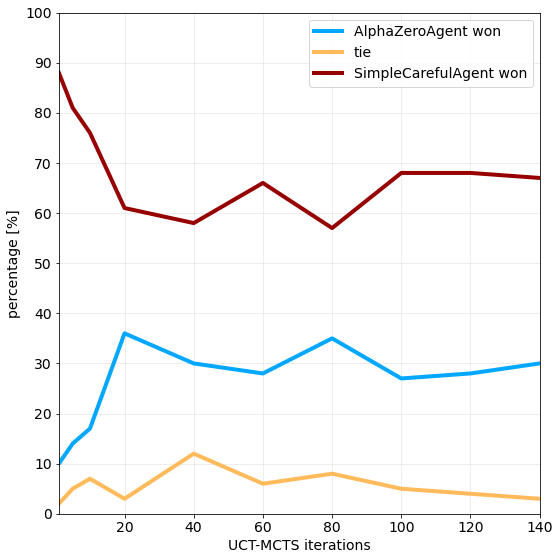

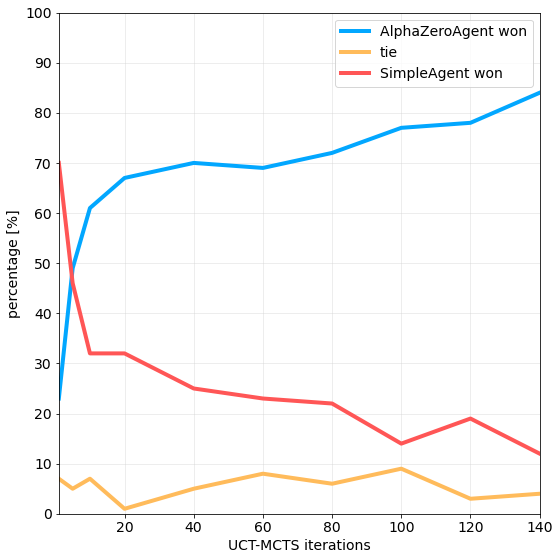

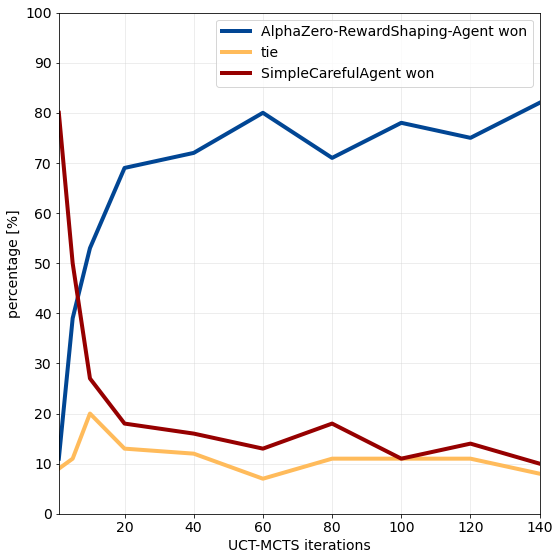

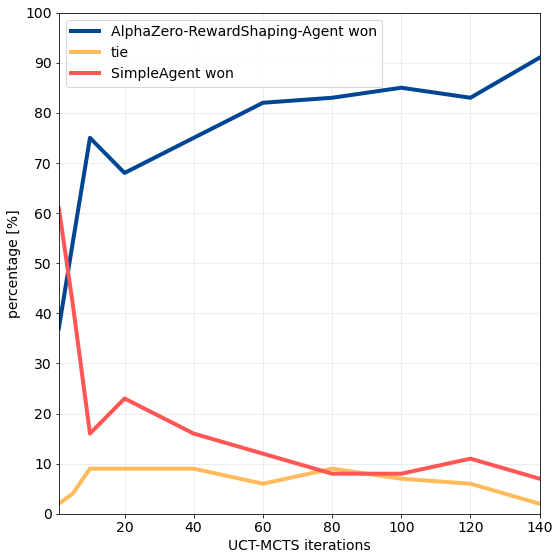

In [17]:
result_azr_care = getResultDataFrame(csv_azr_care, 0, 'AlphaZeroAgent')
result_azr_simple = getResultDataFrame(csv_azr_simple, 0, 'AlphaZeroAgent')
result_az_care = getResultDataFrame(csv_az_care, 0, 'AlphaZeroAgent')
result_az_simple = getResultDataFrame(csv_az_simple, 0, 'AlphaZeroAgent')

filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\AlphaZeroVsSimpleCarefulAgent.png'
showResultPlt(result_az_care, '', 4, 'AlphaZeroAgent', 'SimpleCarefulAgent', agent_colors, False, True, filename=filename)
filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\AlphaZeroVsSimpleAgent.png'
showResultPlt(result_az_simple, '', 4, 'AlphaZeroAgent', 'SimpleAgent', agent_colors, False, True, filename=filename)

filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\AlphaZeroRewardVsSimpleCarefulAgent.png'
showResultPlt(result_azr_care, '', 4, 'AlphaZero-RewardShaping-Agent', 'SimpleCarefulAgent', agent_colors, False, True, filename=filename)
filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\AlphaZeroRewardVsSimpleAgent.png'
showResultPlt(result_azr_simple, '', 4, 'AlphaZero-RewardShaping-Agent', 'SimpleAgent', agent_colors, False, True, filename=filename)

<h1>Calculation time</h1>

UCT-Agent [0, 1.0, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0, 100.0] [0, 0.002920572708333333, 0.010437823521825398, 0.020357449340329837, 0.03696952325396825, 0.07604895083483079, 0.12402952482492996, 0.16050069122157776, 0.20242689990867108]
UCT-ActionPruning-Agent [0, 1.0, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0, 100.0] [0, 0.005980866629182853, 0.025723480903999504, 0.047256611618492414, 0.08818390249777902, 0.17931444001085511, 0.2502116749657441, 0.3224429501184174, 0.40311003625274316]
MiniMax-UCT-Agent [0, 1.0, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0] [0, 0.03812782628027419, 0.22726982894256778, 0.5637106390386112, 1.139545594362488, 1.9318227838875104, 2.6755494613845716, 3.65585626170842]
AlphaZeroAgent [0, 1.0, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0, 100.0] [0, 0.00931141203639305, 0.017397876623762038, 0.030260758456991953, 0.05579016882634892, 0.10772426981459346, 0.1532293823468122, 0.21744235961452338, 0.2580511055483543]
AlphaZero-RewardShaping-Agent [0, 1.0, 5.0, 10.0, 20.0, 40.0, 60.0, 80.0,

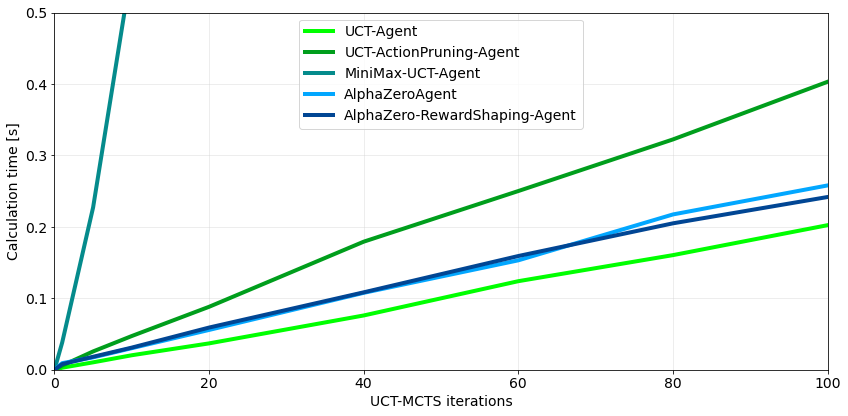

In [16]:
csv_UCT = pd.read_csv("C:\\tmp\\Results\\CSV\\TIMECHECK_UCTAgent_SimpleAgent_03-12-2021_14-15-02.csv", sep=';')
csv_AP = pd.read_csv("C:\\tmp\\Results\\CSV\\TIMECHECK_UCTLimitAgent_SimpleAgent_03-12-2021_14-44-41.csv", sep=';')
csv_MR = pd.read_csv("C:\\tmp\\Results\\CSV\\UCTvarDL_SimpleCarefulAgent_02-20-2021_20-18-57.csv", sep=';')
csv_NN = pd.read_csv("C:\\tmp\\Results\\CSV\\TIMECHECK_AlphaZeroNoRew_SimpleAgent_03-12-2021_22-24-23.csv", sep=';')
csv_NNR = pd.read_csv("C:\\tmp\\Results\\CSV\\TIMECHECK_AlphaZeroRew_SimpleAgent_03-12-2021_23-01-49.csv", sep=';')

df_UCT = getResultDataFrame(csv_UCT, 0, 'AlphaZeroAgent')
df_AP = getResultDataFrame(csv_AP, 0, 'AlphaZeroAgent')
df_MR = getResultDataFrame(csv_MR, 0, 'UcbMRLimitMCTSAgent')
df_NN = getResultDataFrame(csv_NN, 0, 'AlphaZeroAgent')
df_NNR = getResultDataFrame(csv_NNR, 0, 'AlphaZeroAgent')


def plot_calctime(df, a_name):
    iters = list(df['iterations'])
    
    times = list(df['avgtime'])
    for i, t in enumerate(times):
        times[i] = t.mean()
        
    print(a_name, [0] + iters, [0] + times)
        
    # plot
    plt.plot([0] + iters, [0] + times, color=agent_colors[a_name], linewidth=4, label=a_name)

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '14'

plot_calctime(df_UCT, 'UCT-Agent')
plot_calctime(df_AP, 'UCT-ActionPruning-Agent')
plot_calctime(df_MR, 'MiniMax-UCT-Agent')
plot_calctime(df_NN, 'AlphaZeroAgent')
plot_calctime(df_NNR, 'AlphaZero-RewardShaping-Agent')
  
# Custom x axis
#plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
#if over_time:
#    plt.xlim(0, 4)
#else:

iters = list(df_UCT['iterations'])

plt.xlim(0, iters[-1])
plt.ylim(0, 0.5)
plt.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
plt.title('')
plt.legend()
    
plt.ylabel("Calculation time [s]")
plt.xlabel("UCT-MCTS iterations")
    
filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\Agents_TimeComparison.png'
if filename:
    plt.tight_layout()
    plt.savefig(filename)

# Show graphic
plt.show()

<h1>Color Overview<h1!>

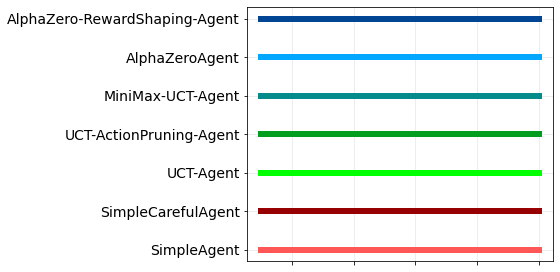

In [44]:
plt.figure(figsize=(8,4))
plt.rcParams['font.size'] = '14'

agents = ['SimpleAgent', 'SimpleCarefulAgent', 'UCT-Agent', 'UCT-ActionPruning-Agent', 'MiniMax-UCT-Agent', 'AlphaZeroAgent', 'AlphaZero-RewardShaping-Agent']

for i, a in enumerate(agents):
    plt.plot([1, 10], [i, i], color=agent_colors[a], linewidth=6)

plt.yticks(list(range(len(agents))), agents)
plt.xticks([2, 4, 6, 8, 10], ['', '', '', '', ''])

plt.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

filename = 'C:\\Users\\marku\\Documents\\Studium\\Semester6\\Bachelorarbeit\\Bilder\\Agent_colors.png'
if filename:
    plt.tight_layout()
    plt.savefig(filename)

# Show graphic
plt.show()